# Chapter 4: Bài toán phân loại đa lớp (Multi-category Classification Problem)

# Lab 4: Mô hình phân loại đa lớp dựa trên CNN (CNN-Based Multi-category Classification Model)

Tập dữ liệu CIFAR-10 được sử dụng để huấn luyện và đánh giá hiệu năng của các mô hình phân loại đa lớp. Trong quá trình huấn luyện, Categorical Cross-Entropy và Adam lần lượt được sử dụng làm hàm mất mát (loss function) và bộ tối ưu (optimizer). Các mô hình mạng được triển khai trong ba kịch bản khác nhau, được mô tả như sau:

Model-1: Mạng neural fully connected.

Model-2: Mạng neural tích chập (Convolutional Neural Network).

Model-3: Kiến trúc mạng giống hệt Model-2, nhưng áp dụng kỹ thuật image augmentation để tăng số lượng và độ đa dạng của dữ liệu huấn luyện.

# 1. Chuẩn bị dữ liệu (Preparing data)
a) Import packages

In [38]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

TensorFlow Datasets

Nếu TensorFlow Datasets chưa được cài đặt, hãy cài đặt bằng một trong các lệnh sau:

pip install tensorflow-datasets


In [39]:
#pip install tensorflow-datasets


#b) Đọc và phân tích dữ liệu (Data reading and analysis)

• Xem danh sách các dataset hiện có trong TensorFlow Datasets:

In [40]:
tfds.list_builders()


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

• Load tập dữ liệu CIFAR-10:

In [41]:
# Chia dữ liệu thành tập huấn luyện và tập validation theo tỉ lệ 9:1
train_split, valid_split = ['train[:90%]', 'train[90%:]']

# Lấy dữ liệu huấn luyện
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)

# Lấy dữ liệu validation
valid_data = tfds.load("cifar10", split=valid_split)

# Lấy dữ liệu test
test_data = tfds.load("cifar10", split="test")


• Hiển thị thông tin CIFAR-10:

In [42]:
print(info)


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Kr

• Hiển thị 10 lớp của CIFAR-10:

In [43]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

• Xem dữ liệu huấn luyện và tính số lượng mẫu của mỗi lớp:

In [44]:
# Tạo dictionary để đếm số lượng nhãn của từng lớp
train_dict = {}

# Đọc toàn bộ tập dữ liệu huấn luyện
for data in train_data:
    # Chuyển label sang định dạng numpy
    label = data['label'].numpy()
    # Đếm số lượng của mỗi lớp
    train_dict[label] = train_dict.setdefault(label, 0) + 1

print(train_dict)


{np.int64(7): 4500, np.int64(8): 4456, np.int64(4): 4497, np.int64(6): 4505, np.int64(5): 4503, np.int64(2): 4522, np.int64(9): 4453, np.int64(3): 4526, np.int64(0): 4530, np.int64(1): 4508}


• Hiển thị ảnh:

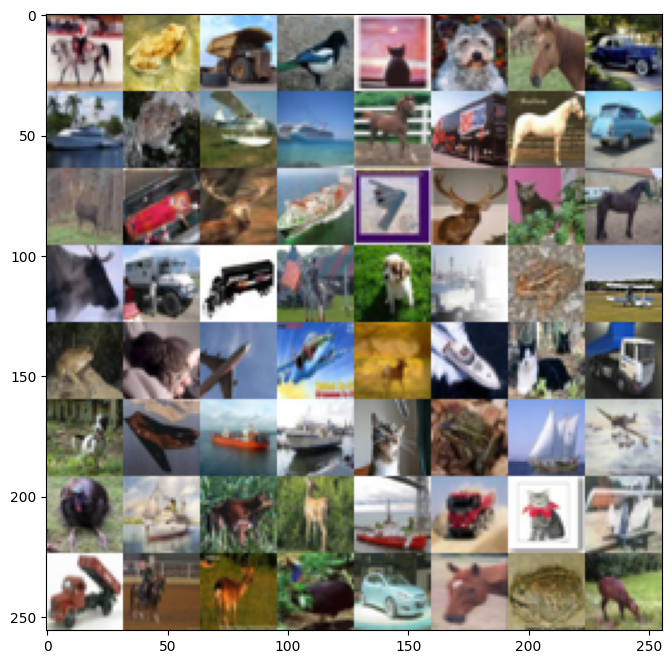

In [45]:
# Tạo mảng để hiển thị ảnh
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0

# Mỗi lần hiển thị 8 ảnh, tổng cộng 8 lần (64 ảnh)
for data in train_data.batch(8).take(8):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1

plt.figure(figsize=(8, 8))
plt.imshow(output)


# c) Phân chia và tiền xử lý dữ liệu (Data division)

• Chuyển đổi dữ liệu:

Image data: chuẩn hóa ảnh bằng cách chia tất cả pixel cho 255 để đưa giá trị pixel về miền 0 đến 1.

Label data: sử dụng One-hot encoding, ví dụ lớp 2 được biểu diễn dưới dạng [0, 0, 1, 0, ...].

In [46]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y


• Thiết lập dữ liệu huấn luyện, validation và test:

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_num = int(info.splits['train'].num_examples / 10) * 9

train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


# 2. Xây dựng và huấn luyện mô hình (Building and training network models)

# a) Model-1: Mạng neural fully connected
Kiến trúc Model-1:

Input layer kích thước 32×32×3

Sáu fully connected layers với ReLU

Sáu Dropout layers với tỉ lệ loại bỏ 30%

Output layer gồm 10 neuron với Softmax

In [48]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_1 = keras.Model(inputs, outputs, name='model-1')

• Tạo thư mục lưu model:

In [49]:
model_dir = 'lab4-logs/models'
os.makedirs(model_dir, exist_ok=True)

• Callback:

In [68]:
import os
from tensorflow import keras

model_dir = 'lab4-logs/models'
os.makedirs(model_dir, exist_ok=True)

# Callback cho model 1
model_cbk_1 = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')
model_mckp_1 = keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/Best-model-1.keras',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max'
)

# Callback cho model 2
model_cbk_2 = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-2')
model_mckp_2 = keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/Best-model-2.keras',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max'
)

# Callback cho model 3
model_cbk_3 = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-3')
model_mckp_3 = keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/Best-model-3.keras',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max'
)


Compile và huấn luyện Model-1:

In [71]:
model_1.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)




In [75]:
history_1 = model_1.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=[model_cbk_1, model_mckp_1]
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - categorical_accuracy: 0.9709 - loss: 0.1047 - val_categorical_accuracy: 0.7218 - val_loss: 2.6116
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9708 - loss: 0.1074 - val_categorical_accuracy: 0.7198 - val_loss: 2.5530
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9716 - loss: 0.0964 - val_categorical_accuracy: 0.7200 - val_loss: 2.5648
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - categorical_accuracy: 0.9734 - loss: 0.0945 - val_categorical_accuracy: 0.7120 - val_loss: 2.8361
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9706 - loss: 0.1054 - val_categorical_accuracy: 0.7224 - val_loss: 2.7777
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9749 - loss: 0.0827 - val_categorical_accuracy: 0.7190 - val_loss: 2.6881
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accura

# b) Model-2: Convolutional Neural Network (không dùng image augmentation)

Kiến trúc Model-2:

Input layer 32×32×3

5 convolutional layers với ReLU

1 max pooling layer

1 fully connected layer (64 neurons, ReLU)

Output layer (10 neurons, Softmax)

In [76]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_2 = keras.Model(inputs, outputs, name='model-2')

• Compile và huấn luyện Model-2:

In [77]:
model_2.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

history_2 = model_2.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=[model_cbk_2, model_mckp_2]
)


Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - categorical_accuracy: 0.2184 - loss: 2.0609 - val_categorical_accuracy: 0.4226 - val_loss: 1.5889
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - categorical_accuracy: 0.4410 - loss: 1.5426 - val_categorical_accuracy: 0.5482 - val_loss: 1.2444
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.5117 - loss: 1.3556 - val_categorical_accuracy: 0.5850 - val_loss: 1.1538
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.5656 - loss: 1.2235 - val_categorical_accuracy: 0.5942 - val_loss: 1.1408
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - categorical_accuracy: 0.6053 - loss: 1.1194 - val_categorical_accuracy: 0.6404 - val_loss: 1.0097
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.6355 - loss: 1.0379 - val_categorical_accuracy: 0.6642 - val_loss: 0.9263
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accura

# Image Augmentation

• Xây dựng các hàm hỗ trợ: flip, color conversion, rotation, zoom (giữ nguyên code).

# c) Model-3: CNN có áp dụng image augmentation

Kiến trúc Model-3: giống Model-2, nhưng dữ liệu huấn luyện đã được tăng cường bằng image augmentation.

In [78]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_3 = keras.Model(inputs, outputs, name='model-3')

• Compile và huấn luyện Model-3:

In [86]:
model_3.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

history_3 = model_3.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=[model_cbk_3, model_mckp_3]
)


Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - categorical_accuracy: 0.8964 - loss: 0.3010 - val_categorical_accuracy: 0.7178 - val_loss: 1.2706
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - categorical_accuracy: 0.9076 - loss: 0.2642 - val_categorical_accuracy: 0.7148 - val_loss: 1.3963
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - categorical_accuracy: 0.9055 - loss: 0.2731 - val_categorical_accuracy: 0.7300 - val_loss: 1.1928
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - categorical_accuracy: 0.9140 - loss: 0.2518 - val_categorical_accuracy: 0.7196 - val_loss: 1.3424
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9140 - loss: 0.2448 - val_categorical_accuracy: 0.7180 - val_loss: 1.3908
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - categorical_accuracy: 0.9240 - loss: 0.2259 - val_categorical_accuracy: 0.7164 - val_loss: 1.3273
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - categorical_accur

# 3. Hiển thị và so sánh kết quả (Displaying results)

• Load trọng số các mô hình và đánh giá:

In [88]:
import os
os.listdir("lab4-logs/models")


['Best-model-1.keras', 'Best-model-2.keras', 'Best-model-3.keras']

In [89]:
import keras

model_1 = keras.saving.load_model('lab4-logs/models/Best-model-1.keras')
model_2 = keras.saving.load_model('lab4-logs/models/Best-model-2.keras')
model_3 = keras.saving.load_model('lab4-logs/models/Best-model-3.keras')

loss_1, acc_1 = model_1.evaluate(test_data, verbose=0)
loss_2, acc_2 = model_2.evaluate(test_data, verbose=0)
loss_3, acc_3 = model_3.evaluate(test_data, verbose=0)

print(f"Model 1: loss={loss_1:.4f}, acc={acc_1:.4f}")
print(f"Model 2: loss={loss_2:.4f}, acc={acc_2:.4f}")
print(f"Model 3: loss={loss_3:.4f}, acc={acc_3:.4f}")


Model 1: loss=3.6959, acc=0.7210
Model 2: loss=2.4332, acc=0.7317
Model 3: loss=1.1429, acc=0.7390


• Tổng hợp loss và accuracy:

In [87]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]

dict = {
    "Loss": loss,
    "Accuracy": acc
}

df = pd.DataFrame(dict)
